In [3]:
from google.colab import files

# upload an image file
uploaded = files.upload()

# access the filename
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')

Saving istanbul.jpg to istanbul.jpg
Uploaded file: istanbul.jpg


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

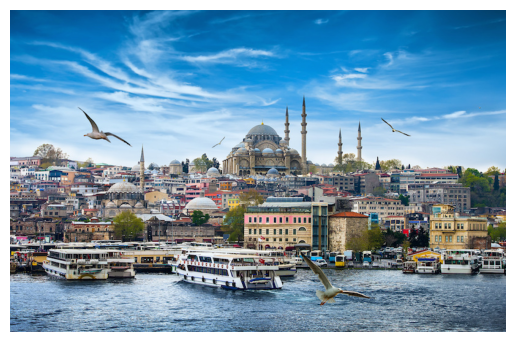

In [5]:
# load the uploaded image
image_path = list(uploaded.keys())[0]  # get the first uploaded file's name
image = Image.open(image_path)
image_np = np.array(image)

# display the image
plt.imshow(image_np)
plt.axis('off')  # turn off axis numbers and ticks
plt.show()

In [67]:
# custom matrix multiplication function

def matrix_multiply(A, B):
    # manually perform matrix multiplication between 3x3 matrices A and B
    result = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
    for i in range(3):
        for j in range(3):
            result[i][j] = sum(A[i][k] * B[k][j] for k in range(3))
    return result

In [68]:
# custom function to find the inverse of a 3x3 matrix

def matrix_inverse(matrix):
    det = (matrix[0][0] * (matrix[1][1] * matrix[2][2] - matrix[1][2] * matrix[2][1])
            - matrix[0][1] * (matrix[1][0] * matrix[2][2] - matrix[1][2] * matrix[2][0])
            + matrix[0][2] * (matrix[1][0] * matrix[2][1] - matrix[1][1] * matrix[2][0]))

    if det == 0:
        raise ValueError("matrix is not invertible")

    inv_det = 1 / det
    inverse = [
        [
            inv_det * (matrix[1][1] * matrix[2][2] - matrix[1][2] * matrix[2][1]),
            inv_det * (matrix[0][2] * matrix[2][1] - matrix[0][1] * matrix[2][2]),
            inv_det * (matrix[0][1] * matrix[1][2] - matrix[0][2] * matrix[1][1])
        ],
        [
            inv_det * (matrix[1][2] * matrix[2][0] - matrix[1][0] * matrix[2][2]),
            inv_det * (matrix[0][0] * matrix[2][2] - matrix[0][2] * matrix[2][0]),
            inv_det * (matrix[0][2] * matrix[1][0] - matrix[0][0] * matrix[1][2])
        ],
        [
            inv_det * (matrix[1][0] * matrix[2][1] - matrix[1][1] * matrix[2][0]),
            inv_det * (matrix[0][1] * matrix[2][0] - matrix[0][0] * matrix[2][1]),
            inv_det * (matrix[0][0] * matrix[1][1] - matrix[0][1] * matrix[1][0])
        ]
    ]
    return inverse

In [69]:
# define the transform matrix based on the homework instructions

def get_affine_transform_matrix(height, width):
    # manually define transformation parameters
    scale_factor = 1.4
    cos_theta = 0.5  # cos(60 degrees)
    sin_theta = 0.86602540378  # sin(60 degrees)

    # define transformation matrices
    scale_matrix = [
        [scale_factor, 0, 0],
        [0, scale_factor, 0],
        [0, 0, 1]
    ]

    rotation_matrix = [
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]

    shear_matrix = [
        [1, 1.4, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]

    # center translation matrices
    center_x, center_y = width / 2, height / 2
    translate_to_origin = [
        [1, 0, -center_x],
        [0, 1, -center_y],
        [0, 0, 1]
    ]

    translate_back = [
        [1, 0, center_x],
        [0, 1, center_y],
        [0, 0, 1]
    ]

    # apply the transformations in the specified order
    transform_matrix = matrix_multiply(
        translate_back,
        matrix_multiply(
            shear_matrix,
            matrix_multiply(
                rotation_matrix,
                matrix_multiply(scale_matrix, translate_to_origin)
            )
        )
    )

    # calculate inverse transform matrix
    inverse_transform_matrix = matrix_inverse(transform_matrix)

    return transform_matrix, inverse_transform_matrix

# get the image dimensions (height and width)
height, width = image_np.shape[:2]

# create the transform and inverse transform matrices
transform_matrix, inverse_transform_matrix = get_affine_transform_matrix(height, width)


In [80]:
# define the forward mapping function

def apply_affine_transform_forward(image, transform_matrix):
    # extract the height and width from the (height, width, channels) object
    height = len(image)
    width = len(image[0])

    # create an empty list for the transformed image with the same dimensions
    transformed_image = [[[0, 0, 0] for _ in range(width)] for _ in range(height)]  # initialize for RGB

    # iterate over each pixel in the image (x=row, y=col)
    for x in range(height):
        for y in range(width):
            # manually calculate the transformed coordinates
            new_x = int(transform_matrix[0][0] * x + transform_matrix[0][1] * y + transform_matrix[0][2])
            new_y = int(transform_matrix[1][0] * x + transform_matrix[1][1] * y + transform_matrix[1][2])

            # ensure the new coordinates are within the bounds of the transformed image
            if 0 <= new_x < height and 0 <= new_y < width:
                transformed_image[new_x][new_y] = image[x][y]

    return transformed_image

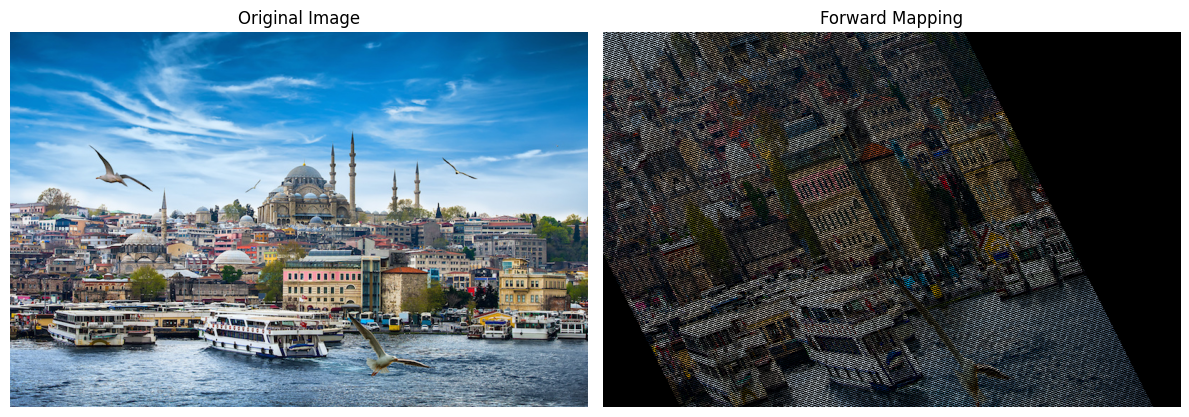

In [81]:
# apply the forward mapping
transformed_image_forward = apply_affine_transform_forward(image_np, transform_matrix)

# create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# display the original image
axs[0].imshow(image_np)
axs[0].set_title('Original Image')
axs[0].axis('off')  # hide axis

# display the transformed image
axs[1].imshow(transformed_image_forward)
axs[1].set_title('Forward Mapping')
axs[1].axis('off')  # hide axis

# show the combined images
plt.tight_layout()
plt.show()

In [74]:
# define the backward mapping without interpolation

def apply_affine_transform_backward_no_interpolation(image, inverse_matrix):
    # extract the height and width from the image
    height = len(image)
    width = len(image[0])

    # initialize an empty array with a default value (e.g., black color)
    transformed_image = [[[0, 0, 0] for _ in range(width)] for _ in range(height)]  # RGB channels

    # iterate over the image's pixels
    for x in range(height):
        for y in range(width):
            # set the destination coordinates to current pixel coordinates
            dest_coord = [x, y, 1]

            # manually calculate the source coordinates
            source_x = int(inverse_matrix[0][0] * dest_coord[0] +
                            inverse_matrix[0][1] * dest_coord[1] +
                            inverse_matrix[0][2] * dest_coord[2])
            source_y = int(inverse_matrix[1][0] * dest_coord[0] +
                            inverse_matrix[1][1] * dest_coord[1] +
                            inverse_matrix[1][2] * dest_coord[2])

            # ensure the source coordinates are within bounds
            if 0 <= source_x < height and 0 <= source_y < width:
                transformed_image[x][y] = image[source_x][source_y]

    return transformed_image

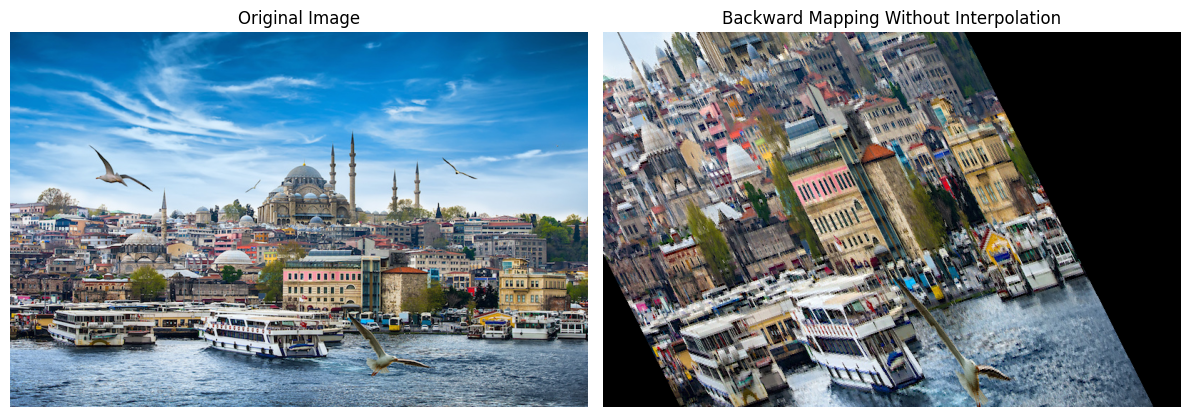

In [75]:
# apply the backward mapping without interpolation

transformed_image_backward_no_interp = apply_affine_transform_backward_no_interpolation(image_np, inverse_transform_matrix)

# create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# display the original image
axs[0].imshow(image_np)
axs[0].set_title('Original Image')
axs[0].axis('off')  # hide axis

# display the transformed image
axs[1].imshow(transformed_image_backward_no_interp)
axs[1].set_title('Backward Mapping Without Interpolation')
axs[1].axis('off')  # hide axis

# show the combined images
plt.tight_layout()
plt.show()

In [76]:
# define bilinear interpolation algorithm

def bilinear_interpolation(image, x, y):
    # this algorithm gives the added pixels a value
    # based on how close they are to the image center

    # get the nearest integer values
    x1, y1 = int(x), int(y)

    # taking x1 + 1 and the last index to stay within the bounds
    x2, y2 = min(x1 + 1, image.shape[0] - 1), min(y1 + 1, image.shape[1] - 1)

    # weights for the interpolation
    # each pixel contributes based on how close it is to (x,y)
    a = x - x1 # horizontal fractional distance
    b = y - y1 # vertical fractional distance

    # compute the interpolated value
    # less a or b means it's closer to a;
    # so (1-a) or (1-b) ensures that we give it a higher value closer to 1

    # top left = lower a, lower b
    # top right = higher a, lower b
    # bot left = lower a, higher b
    # bot right = higher a, higher b

    # this way the center points gives from it's value to it's neighbors
    # depending on how close the edges are to the center
    result = (1 - a) * (1 - b) * image[x1, y1] + a * (1 - b) * image[x2, y1] + \
             (1 - a) * b * image[x1, y2] + a * b * image[x2, y2]

    return result

In [77]:
# define backward mapping with bilinear interpolation function

def apply_affine_transform_backward_bilinear(image, inverse_matrix):
    height = len(image)
    width = len(image[0])

    # prepare an empty transformed image with the same size
    # 3 channels (RGB)
    transformed_image = [[[0 for _ in range(3)] for _ in range(width)] for _ in range(height)]

    for x in range(height):
        for y in range(width):
            # compute destination coordinates
            dest_coord = [x, y, 1]

            # manually perform matrix multiplication to find source coordinates
            source_x = (inverse_matrix[0][0] * dest_coord[0] +
                         inverse_matrix[0][1] * dest_coord[1] +
                         inverse_matrix[0][2] * dest_coord[2])

            source_y = (inverse_matrix[1][0] * dest_coord[0] +
                         inverse_matrix[1][1] * dest_coord[1] +
                         inverse_matrix[1][2] * dest_coord[2])

            # apply bilinear interpolation if the source pixel is within bounds
            if 0 <= source_x < height and 0 <= source_y < width:
                transformed_image[x][y] = bilinear_interpolation(image, source_x, source_y)

    return transformed_image


In [78]:
# function to clip the values to stay between 0 and 255

def clip_and_convert(image):
    height = len(image)
    width = len(image[0])
    converted_image = [[[0 for _ in range(3)] for _ in range(width)] for _ in range(height)]  # 3 channels (rgb)

    for x in range(height):
        for y in range(width):
            for c in range(3):  # for each color channel
                # clip values to the range [0, 255]
                pixel_value = image[x][y][c]
                if pixel_value < 0:
                    converted_image[x][y][c] = 0
                elif pixel_value > 255:
                    converted_image[x][y][c] = 255
                else:
                    converted_image[x][y][c] = int(pixel_value)

    return converted_image

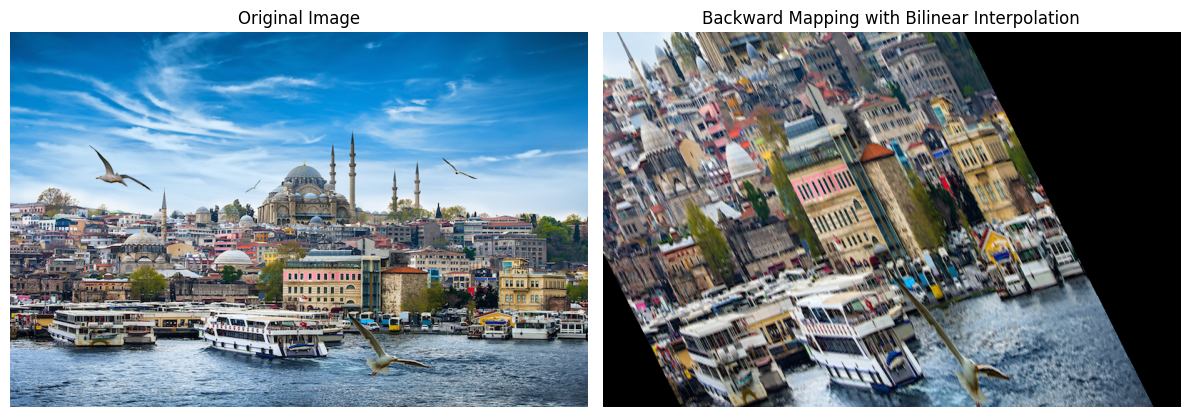

In [79]:
# apply backward mapping with bilinear interpolation
transformed_image_backward_bilinear = apply_affine_transform_backward_bilinear(image_np, inverse_transform_matrix)

# clip and convert the transformed image
transformed_image_backward_bilinear = clip_and_convert(transformed_image_backward_bilinear)

# create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# display the original image
# ensure original image is in a format compatible with display
original_image = clip_and_convert(image_np)  # image_np is a list of lists
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[0].axis('off')  # hide axis

# display the transformed image
axs[1].imshow(transformed_image_backward_bilinear)
axs[1].set_title('Backward Mapping with Bilinear Interpolation')
axs[1].axis('off')  # hide axis

# show the combined images
plt.tight_layout()
plt.show()